In [15]:
from langchain_ollama import ChatOllama
from langchain.schema import HumanMessage
from pydantic import BaseModel, Field
from enum import Enum
from langgraph.graph import Graph
from IPython.display import Image, display

# Definizione del modello di output
class TipoPersona(str, Enum):
    fisica = "fisica"
    giuridica = "giuridica"

# PersonaOutput: modello Pydantic che vincola la struttura dell’output
class PersonaOutput(BaseModel):
    tipo: TipoPersona = Field(description="Tipo di persona: 'fisica' o 'giuridica'")

# Inizializza LLM
llm = ChatOllama(model="llama3.2", temperature=0)

# Nodo 1 – classifica → usa ChatOllama per determinare se la persona è fisica o giuridica
def classifica_persona(input_str: str) -> PersonaOutput:
    
    prompt = f"""
    Determina se il seguente nome si riferisce a una persona fisica o giuridica.
    Rispondi solo con 'fisica' o 'giuridica'.

    Nome: {input_str}
    """
    # forza il modello ChatOllama a restituire output validato
    response = llm.with_structured_output(PersonaOutput).invoke([HumanMessage(content=prompt)])
    return response

# Nodo 2 – log_result → registra o elabora il risultato (es. stampa o salvataggio)
def log_result(result: PersonaOutput) -> PersonaOutput:
    print(f"[LOG] Tipo rilevato: {result.tipo}")
    # Qui potresti anche salvare su DB o file
    return result  # restituisce per mantenere output coerente

# Creazione grafo
graph = Graph()

# Aggiunge i due nodi
graph.add_node("classifica", classifica_persona)
graph.add_node("log_result", log_result)

# Definisce il flusso
graph.add_edge("classifica", "log_result")

# Entry point
graph.set_entry_point("classifica")
graph.set_finish_point("log_result")

# Compilazione
app = graph.compile()

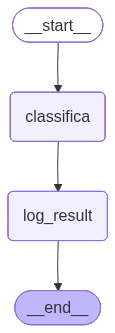

In [17]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
# Esecuzione

input_text = "Alfa S.R.L."
output = app.invoke(input_text)
print("Output finale:", output)

[LOG] Tipo rilevato: giuridica
Output finale: tipo=<TipoPersona.giuridica: 'giuridica'>


In [22]:
print(output.model_dump())

{'tipo': <TipoPersona.giuridica: 'giuridica'>}


In [23]:
print(output.model_dump_json())

{"tipo":"giuridica"}
